## Explore Piece Classification Results

A 13xN grid of classified training data.

N is the minimum number of examples predicted by the model on the current batch. 
(Discover if train_generator is very uneven.)


### Training data results

In [1]:
from square_classifier import load_classifier
from train_square_classifier import get_train_generator
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

num_classes = 13
batch_size = 400

train_generator = get_train_generator(batch_size=batch_size)
# Class weighting

# Even out classes or leave as "in the wild?"

#https://stackoverflow.com/questions/44666910/keras-image-preprocessing-unbalanced-data
#https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory
#train_datagen.fit()

# Build the model
model = load_classifier()

# Get a batch of training data
im_batch, _ = next(train_generator)

Using Theano backend.


Found 5636 images belonging to 13 classes.
Loading square model..
Loading square model.. DONE


In [2]:
from collections import Counter

counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}        
print(class_weights)

{0: 2.119047619047619, 1: 3.16600790513834, 2: 2.503125, 3: 1.044328552803129, 4: 3.575892857142857, 5: 1.6757322175732217, 6: 2.3628318584070795, 7: 2.661129568106312, 8: 2.4798761609907123, 9: 1.0737265415549597, 10: 3.323651452282158, 11: 1.7225806451612904, 12: 1.0}


In [3]:
im_batch, _ = next(train_generator)
label_names  = ['B', 'K', 'N', 'P', 'Q', 'R', 'b', 'k', 'n', 'p', 'q', 'r', 'f']

In [4]:
# Predict a batch & compute min 

label_names  = ['B', 'K', 'N', 'P', 'Q', 'R', 'b', 'k', 'n', 'p', 'q', 'r', 'f']

class_probs = model.predict(im_batch)

predictions = np.argmax(class_probs, axis=1)
pred_labels = [label_names[p] for p in predictions]

# Get the minimum number of predictions for each class
counter = Counter(pred_labels)                          
num_sq = int(min(counter.values()))

print("With a batch size of {}, we have at least {} predictions of each class.".format(batch_size, num_sq))
print("If the generator was balanced, we would expect around {}.".format(round(float(batch_size)/num_classes)))

With a batch size of 400, we have at least 17 predictions of each class.
If the generator was balanced, we would expect around 31.


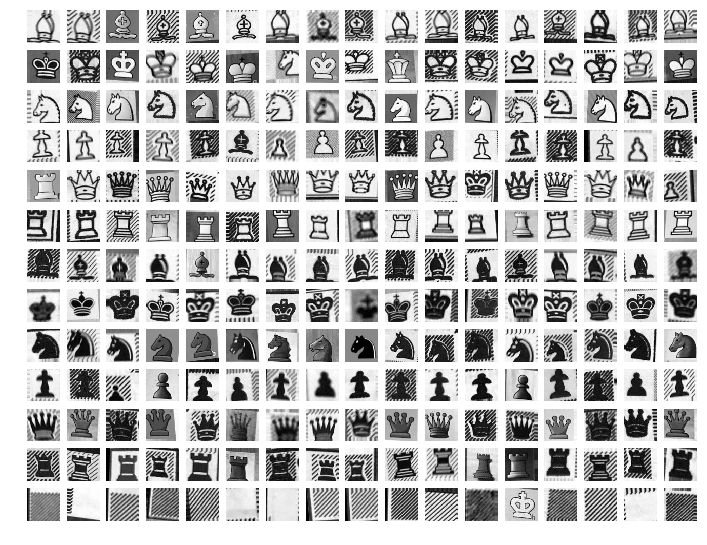

In [5]:
# Plot a grid of pieces

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

rows, cols = num_classes, num_sq

fig = plt.figure(1, figsize=(12, 12))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 share_all=True,
                 label_mode=None
                 )

for i, class_name in enumerate(label_names):
    k = 0
    for j in range(cols):
        # get a new image from im_batch with pred_label class_name
        while pred_labels[k] != class_name:
            k += 1
        ax = grid[cols*i+j]
        ax.imshow(im_batch[k].reshape(64, 64), cmap="gray")
        ax.axis("off")
        k += 1

#plt.savefig("../../img/training_classification11.png", bbox_inches="tight")
plt.show()

### Test data results

- get batch of raw images (N=5)
- extract boards
- extract squares (N * 64) -> batch
- same as above: count min_sq and plot a grid

In [6]:
from util import listdir_nohidden
from u_net import load_extractor
from extract_squares import extract_squares
import cv2 
import u_net as unet
import numpy as np

num_boards = 5

raw_dir = "../../data/raw/"
raw_imgs = listdir_nohidden(raw_dir)
raw_batch = np.random.choice(raw_imgs, num_boards)

raw_imgs = list(map(lambda f: cv2.imread(raw_dir + f), raw_batch))
resized_imgs = list(map(lambda im: cv2.resize(im, (256, 256), interpolation=cv2.INTER_AREA), raw_imgs))

extract_model = load_extractor()


Loading board extraction model..
Loading board extraction model.. DONE


In [7]:
# build list of boards

from board_extractor import extract_board

boards = []
for raw_img, resized_img in zip(raw_imgs, resized_imgs):
    try:
        board = extract_board(resized_img, raw_img, extract_model)
    except Exception as e:
        print(e)
    boards.append(board)

# transform to a batch of squares
square_batch = []
for b in boards:
    squares, _ = extract_squares(b)
    square_batch.append(squares)

square_batch = np.array(square_batch)
square_batch = np.reshape(square_batch, (num_boards*64, 64, 64, 1))
print(square_batch.shape)

Extracting board..
Extracting board.. DONE
Extracting board..
Extracting board.. DONE
Extracting board..
Extracting board.. DONE
Extracting board..
Extracting board.. DONE
Extracting board..
Extracting board.. DONE
(320, 64, 64, 1)


In [8]:
class_probs = model.predict(square_batch)
predictions = np.argmax(class_probs, axis=1)
pred_labels = [label_names[p] for p in predictions]

# Get the minimum number of predictions for each class
counter = Counter(pred_labels)                          
num_sq = int(min(counter.values()))

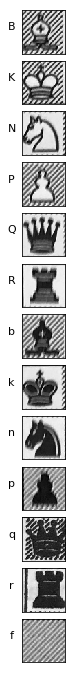

In [9]:
import matplotlib.pyplot as plt

rows, cols = num_classes, num_sq

fig = plt.figure(2, figsize=(12, 12))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 share_all=True,
                 label_mode=None
                 )

for i, class_name in enumerate(label_names):
    k = 0
    for j in range(cols):
        # get a new image from im_batch with pred_label class_name
        while pred_labels[k] != class_name:
            k += 1
        ax = grid[cols*i+j]
        ax.imshow(square_batch[k].reshape(64, 64), cmap="gray")
        if j == 0:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_ylabel(class_name, rotation="horizontal", labelpad=10.0, size=11)
        else: 
            ax.axis("off")
            
        
        k += 1
#plt.suptitle("Classification of extracted boards from test set")
#plt.savefig("../../img/test_classification.png", bbox_inches="tight")
plt.show()


## Plot a single classified test image

Extracting board..
Extracting board.. DONE


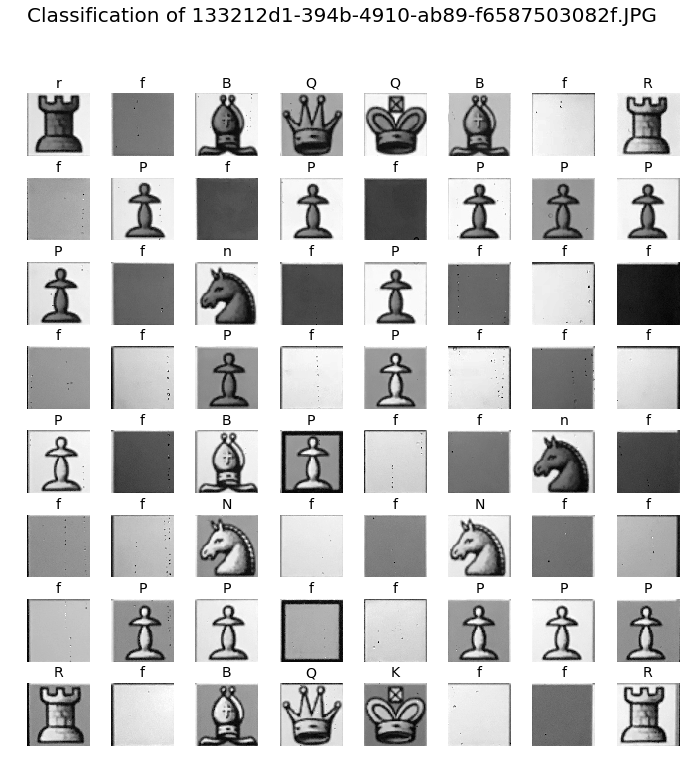

In [12]:
# Load random raw image
raw_files = listdir_nohidden(raw_dir)
example = np.random.choice(raw_files, 1)
raw_img = cv2.imread(raw_dir + example[0])
resized_img = cv2.resize(raw_img, (256, 256), interpolation=cv2.INTER_AREA)

# Extract board
board = extract_board(resized_img, raw_img, extract_model)

squares, names = extract_squares(board)

# Predict squares
class_probs = model.predict(squares)
#print(class_probs)
predictions = np.argmax(class_probs, axis=1)
pred_labels = [label_names[p] for p in predictions]

# Plot
rows, cols = 8, 8
fig = plt.figure(3, figsize=(12, 12))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 share_all=True,
                 label_mode=None
                 )

for i in range(cols):
    for j in range(rows):
        ind = cols*i+j
        im = squares[ind]
        label = pred_labels[ind]
        grid[ind].imshow(im.reshape(64, 64), cmap="gray")
        grid[ind].set_title(label, size=14, fontweight=3)
        grid[ind].axis("off")

plt.suptitle("Classification of {}".format(example[0]), size=20, fontweight=5)
#plt.savefig("../../img/clf_{}.png".format(example[0][:-4]), bbox_inches="tight")
plt.show()